In [4]:
import random
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding,Bidirectional
from keras.optimizers import SGD,RMSprop
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [5]:
def generate_addition_data(dataset, size):
    all_tuples = []
    for i in range(size):
        first_number = random.choice(dataset)
        second_number = random.choice(dataset)
        second_number = random.choice(dataset)
        second_number = random.choice(dataset)
        second_number = random.choice(dataset)
        while second_number == first_number:
            second_number = random.choice(dataset)
        all_tuples.append((first_number,second_number))

    random.shuffle(all_tuples)
    return all_tuples

In [6]:
def generate_max_data(all_numbers, length, num_samples):
    def gaussian_sample(max_index):
        if max_index <= 500: # sample from a small Gaussian
            random_gaussian = np.random.normal(scale=5)
        else: # sample from a big Gaussian
            random_gaussian = np.random.normal(scale=max_index * 0.01)
        new_index = max_index - int(random_gaussian)
        if new_index >= max_index: # if out of bounds
            new_index = max_index - 1
        elif new_index < 0: # if out of bounds
            new_index = 0
        return new_index

    all_numbers = sorted(all_numbers)
    all_lists = []
    minimum = 0; maximum = len(all_numbers) - 1
    for i in range(num_samples):
        max_index = np.random.randint(low=10, high=maximum, size=1)[0] # sample a random number
        temp_list = [all_numbers[max_index]]
        if np.random.uniform() > 0.5: # for half the values, we just randomly sample
            for j in range(length - 1):
                new_int = all_numbers[np.random.randint(low=minimum, high=max_index-1, size=1)[0]]
                while new_int in temp_list: # resample if its already in there
                    new_int = all_numbers[np.random.randint(low=minimum, high=max_index-1, size=1)[0]]
                temp_list.append(new_int)
        else: # for the other half, we sample from a Gaussian to keep the numbers nearby
            for j in range(length - 1):                
                new_int = all_numbers[gaussian_sample(max_index)]
                while new_int in temp_list: # if already oresent, resample                    
                    new_int = all_numbers[gaussian_sample(max_index)]
                temp_list.append(new_int)

        random.shuffle(temp_list) # shuffle inside the examples
        all_lists.append(temp_list)
    random.shuffle(all_lists)
    return all_lists

In [7]:
#create dataset
all_numbers = list(range(0, 1000))
random.shuffle(all_numbers)

trainset=generate_max_data(all_numbers,5,100000)
testset=generate_max_data(all_numbers,5,10000)

In [8]:
#create label
train_label=[]
test_label=[]
for i in range(0,len(trainset)):
    train_label.append(trainset[i].index(max(trainset[i])))
for i in range(0,len(testset)):
    test_label.append(testset[i].index(max(testset[i])))

In [9]:
trainCate = to_categorical(train_label, num_classes=5)
testCate= to_categorical(test_label, num_classes=5) 

In [17]:
nekg=np.load('./1-999 100d step 1/dismult 0-999 100d.npy')

In [18]:
#embed numbers
embedding_matrix = np.zeros((1000, 100))
for i in range(1000):
    embedding_matrix[i]=nekg[i]

In [19]:
#max
batch_size=8
embedder = Embedding(1000, 100, input_length=5, weights=[embedding_matrix], trainable=True)
model=Sequential()
model.add(embedder)
model.add(Bidirectional(LSTM(64)))
model.add(Dense(5,activation="softmax",name="FC2"))
model.summary()
model.compile(loss="categorical_crossentropy",optimizer=RMSprop(),metrics=["accuracy"])


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 5, 100)            100000    
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              84480     
 nal)                                                            
                                                                 
 FC2 (Dense)                 (None, 5)                 645       
                                                                 
Total params: 185,125
Trainable params: 185,125
Non-trainable params: 0
_________________________________________________________________


In [20]:
history=model.fit(np.array(trainset), trainCate, batch_size, epochs=20,validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss',patience=3)])

Epoch 1/20
10000/10000 [==============================] - 21s 2ms/step - loss: 1.3389 - accuracy: 0.3859 - val_loss: 1.0494 - val_accuracy: 0.5352
Epoch 2/20
10000/10000 [==============================] - 19s 2ms/step - loss: 0.8556 - accuracy: 0.6367 - val_loss: 0.6536 - val_accuracy: 0.7281
Epoch 3/20
10000/10000 [==============================] - 19s 2ms/step - loss: 0.5268 - accuracy: 0.7868 - val_loss: 0.4799 - val_accuracy: 0.8059
Epoch 4/20
10000/10000 [==============================] - 20s 2ms/step - loss: 0.3860 - accuracy: 0.8466 - val_loss: 0.4430 - val_accuracy: 0.8277
Epoch 5/20
10000/10000 [==============================] - 19s 2ms/step - loss: 0.3062 - accuracy: 0.8817 - val_loss: 0.4191 - val_accuracy: 0.8366
Epoch 6/20
10000/10000 [==============================] - 19s 2ms/step - loss: 0.2468 - accuracy: 0.9050 - val_loss: 0.3820 - val_accuracy: 0.8565
Epoch 7/20
10000/10000 [==============================] - 19s 2ms/step - loss: 0.2078 - accuracy: 0.9221 - val_loss: 0

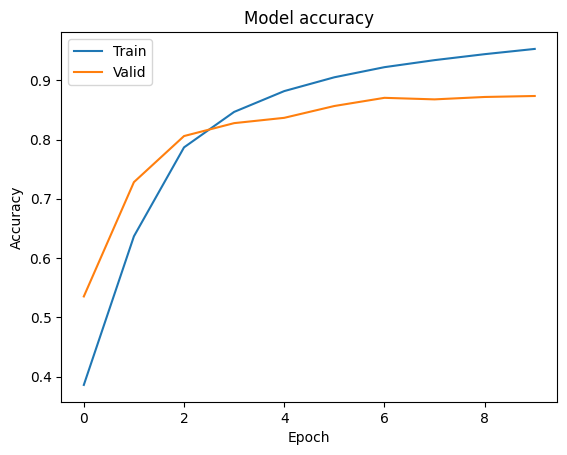

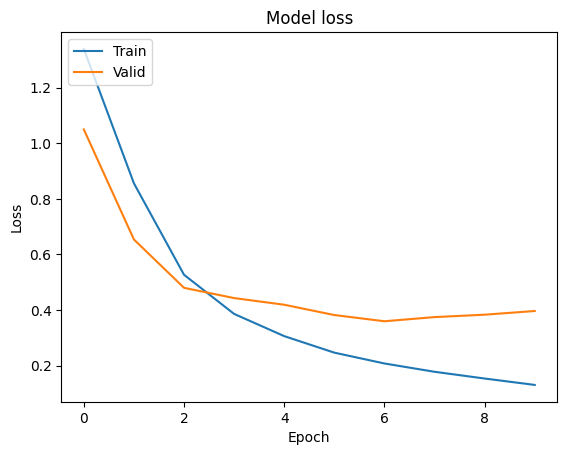

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Valid'],loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Valid'],loc='upper left')
plt.show()

In [16]:
score = model.evaluate(np.array(testset), testCate,batch_size=16)
print(score)

625/625 [==============================] - 1s 1ms/step - loss: 0.3952 - accuracy: 0.8732
[0.3952014744281769, 0.873199999332428]
